# Курсовой проект


Целевая метрика precision@5 > 25%  
Сдаем ссылку на github с решением. На github должен быть файл recommendations.csv (user_id | [rec_1, rec_2, ...] с рекомендациями. rec_i - реальные id item-ов (из retail_train.csv)  

In [1]:
# !pip install lightfm
# !pip install lightgbm

In [2]:
import implicit
implicit.__version__

'0.4.4'

In [3]:
N_ = 200
TOP_N = 2500

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.curdir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [5]:
data = pd.read_csv('../../../datasets/retail_train.csv')
data_test = pd.read_csv('../../../datasets/retail_test1.csv')
item_features = pd.read_csv('../../../datasets/product.csv')
user_features = pd.read_csv('../../../datasets/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.shape, data_val_lvl_1.shape, data_train_lvl_2.shape, data_val_lvl_2.shape

((2108779, 12), (169711, 12), (169711, 12), (118314, 12))

In [6]:
data_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


In [7]:
item_features[['item_id', 'department']].set_index('item_id').head()

,department
item_id,
25671,GROCERY
26081,MISC. TRANS.
26093,PASTRY
26190,GROCERY
26355,GROCERY


In [8]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
#префильтр и оставляем топ-2500

n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=TOP_N)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 2501


Оставляем только пользователей, общих для всех датасетов

In [10]:
common_users = list(set(data_train_lvl_1.user_id.values)&(set(data_val_lvl_1.user_id.values))&set(data_val_lvl_2.user_id.values))

data_train_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

data_train_lvl_1.shape, data_val_lvl_1.shape, data_train_lvl_2.shape, data_val_lvl_2.shape

((1875484, 13), (163261, 12), (163261, 12), (115989, 12))

In [11]:
data_train_lvl_1.user_id.unique().size, data_val_lvl_1.user_id.unique().size, data_train_lvl_2.user_id.unique().size, data_val_lvl_2.user_id.unique().size

(1915, 1915, 1915, 1915)

In [12]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/2501 [00:00<?, ?it/s]

### Подбор количества кандидатов в рекомендации, поиск балланса между максимизацией recall@k и потребелением ресурсов

In [13]:
result_lvl_1 = data_train_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.unique())]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[999999, 840361, 845307, 856942, 940947, 94580..."
1,6,"[840361, 999999, 863447, 907099, 927291, 97003..."


In [14]:
import time
def get_result_level_1_df(N_list, df):
    result = dict()
    for N in N_list:    
        start_time = time.time()
        df[f'als_rec_{N}'] = df['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N))
        print(f'Ready als_rec, N = {N}, Время: {round(time.time() - start_time, 1)} c')
        start_time = time.time()
        df[f'own_rec_{N}'] = df['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N))
        print(f'Ready own_rec, N = {N}, Время: {round(time.time() - start_time, 1)} c')
        start_time = time.time()
        df[f'similar_items_rec_{N}'] = df['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N))
        print(f'Ready similar_items_rec, N = {N}, Время: {round(time.time() - start_time, 1)} c')
#         start_time = time.time()
#         df[f'similar_users_rec_{N}'] = df['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N))
#         print(f'Ready similar_users_rec, N = {N}, Время: {round(time.time() - start_time, 1)} c')
        for col_name in df.columns[2:]:
            recallatk = df.apply(lambda row: recall_at_k(row[col_name], row["actual"], k=N), axis=1).mean()
#             print(f'{col_name}: {recall_at_k}')
            result[f'{col_name}'] = recallatk
            
    return df, result 

In [15]:
df, result = get_result_level_1_df([10, 20, 50, 100, 200, 500, 1000], result_lvl_1)
result

Ready als_rec, N = 10, Время: 14.4 c
Ready own_rec, N = 10, Время: 8.7 c
Ready similar_items_rec, N = 10, Время: 1.9 c
Ready als_rec, N = 20, Время: 14.1 c
Ready own_rec, N = 20, Время: 8.4 c
Ready similar_items_rec, N = 20, Время: 2.7 c
Ready als_rec, N = 50, Время: 14.3 c
Ready own_rec, N = 50, Время: 8.6 c
Ready similar_items_rec, N = 50, Время: 4.8 c
Ready als_rec, N = 100, Время: 14.5 c
Ready own_rec, N = 100, Время: 8.6 c
Ready similar_items_rec, N = 100, Время: 8.0 c
Ready als_rec, N = 200, Время: 15.1 c
Ready own_rec, N = 200, Время: 9.0 c
Ready similar_items_rec, N = 200, Время: 12.8 c
Ready als_rec, N = 500, Время: 16.5 c
Ready own_rec, N = 500, Время: 9.0 c
Ready similar_items_rec, N = 500, Время: 16.9 c
Ready als_rec, N = 1000, Время: 18.8 c
Ready own_rec, N = 1000, Время: 8.9 c
Ready similar_items_rec, N = 1000, Время: 17.0 c


{'als_rec_10': 0.03874506164311251,
 'own_rec_10': 0.09187033499435755,
 'similar_items_rec_10': 0.03079056456599184,
 'als_rec_20': 0.06790537383221718,
 'own_rec_20': 0.16897952102205302,
 'similar_items_rec_20': 0.05475032370520952,
 'als_rec_50': 0.14014381856986974,
 'own_rec_50': 0.3600849804458189,
 'similar_items_rec_50': 0.11218799419135567,
 'als_rec_100': 0.23211739908076687,
 'own_rec_100': 0.5881086924464032,
 'similar_items_rec_100': 0.1849186692795704,
 'als_rec_200': 0.36944731139494674,
 'own_rec_200': 0.8327548308379844,
 'similar_items_rec_200': 0.29000924615570267,
 'als_rec_500': 0.6201220569071852,
 'own_rec_500': 0.977045735660664,
 'similar_items_rec_500': 0.47672461451567644,
 'als_rec_1000': 0.827146078134054,
 'own_rec_1000': 0.9813322132107578,
 'similar_items_rec_1000': 0.6511225089087782}

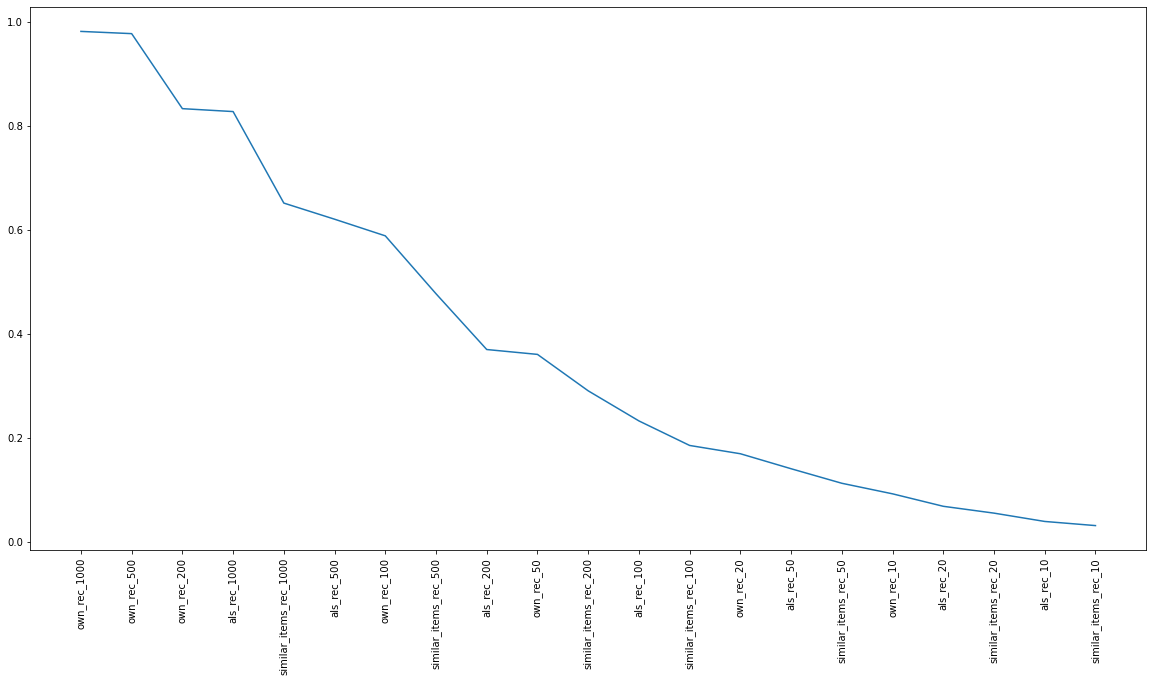

In [16]:
plt.figure(figsize=(20,10))
plt.plot([x[0] for x in Counter(result).most_common()], [x[1] for x in Counter(result).most_common()])
plt.xticks(rotation=90)
plt.show();

Видно, что:
- наиболее высокая метрика recall@k получается при алгоритме get_own_recommendations
- независимо от выбираемого алгоритма, метрика растет с ростом к. При этом c ростом k будет увеличиваться и время формирования рекомендаций, поэтому требуется искать некоторый оптимум k. В данном случае представляется разумным остановиться на k = 200 - 500

### Генерация фичей, обучение модели второго уровня

In [17]:
data_lvl_1 = pd.concat([data_train_lvl_1, data_val_lvl_1])
data_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0,0.82


In [18]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_))

# разворачиваем товары
df_items = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(df_items)
users_lvl_2.head(2)

data_train_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
data_train_lvl_2['target'] = 1  # тут только покупки 

# # Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качестве нулей
data_train_lvl_2 = users_lvl_2.merge(data_train_lvl_2, on=['user_id', 'item_id'], how='left')

# # чистим дубликаты
data_train_lvl_2 = data_train_lvl_2.drop_duplicates(subset=['user_id', 'item_id'])
data_train_lvl_2['target'].fillna(0, inplace= True)

data_train_lvl_2['target'].value_counts()

0.0    338331
1.0     28421
Name: target, dtype: int64

In [19]:
users_test = pd.DataFrame(data_test['user_id'].unique()).rename(columns={0:'user_id'})
users_test['candidates'] = users_test['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_))

df_items = users_test.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

users_test = users_test.drop('candidates', axis=1).join(df_items)
users_test.head(2)

,user_id,item_id
0,1340,1032549
0,1340,874736


In [20]:
def feature_generation(data_lvl_1, data_train_lvl_2, user_features, item_features):
    # user_features
    
    # средний чек
    user_average_bill = data_lvl_1.groupby(["user_id", "basket_id"])[['price']].mean().\
                                        groupby('user_id')['price'].mean()
    user_average_bill.name = "user_average_bill"
    user_features = user_features.merge(user_average_bill, how = 'left', on = 'user_id')
    
    # среднее количество покупок в неделю/месяц
    data_lvl_1['month'] = data_lvl_1['day'].apply(lambda x: (x+30)//30)

    user_monthes_sum_purchase = data_lvl_1.groupby(["user_id"])["month"].nunique()
    user_sum_purchases = data_lvl_1.groupby(['user_id'])['basket_id'].nunique()
    user_purchases_freq_per_month = user_sum_purchases / user_monthes_sum_purchase
    user_purchases_freq_per_month.name = "user_purchases_freq_per_month"

    user_weeks_sum_purchase = data_lvl_1.groupby(["user_id"])["week_no"].nunique()
    user_purchases_freq_per_week = user_sum_purchases / user_weeks_sum_purchase
    user_purchases_freq_per_week.name = "user_purchases_freq_per_week"

    user_features = user_features.merge(user_purchases_freq_per_month, how = 'left', on = 'user_id')
    user_features = user_features.merge(user_purchases_freq_per_week, how = 'left', on = 'user_id')
    
    # item features
    
    # Среднее кол-во покупок item_id в неделю
    item_per_week = data_lvl_1.groupby('item_id')['quantity'].sum().rename('item_per_week') / data_lvl_1['week_no'].max()
    item_features = item_features.merge(item_per_week, how='left', on='item_id', suffixes=(False, False))

    # Средняя частота item в корзине
    item_freq_per_basket = data_lvl_1.groupby(['item_id']).agg('user_id').count().rename('item_freq_per_basket')/data_lvl_1.basket_id.nunique()
    item_features = item_features.merge(item_freq_per_basket, how='left', on='item_id', suffixes=(False, False))

    # цена
    item_price = data_lvl_1.groupby(['item_id']).agg({'quantity': 'sum', 'sales_value': 'sum'})
    item_price = item_price['sales_value'] / item_price['quantity']
    item_price.name = 'item_price'
    item_features = item_features.merge(item_price, how='left', on="item_id", suffixes=(False, False))

    # Среднее кол-во покупок 1 товара в категории в неделю

    data_categ = pd.merge(data_lvl_1, item_features, how='inner', on='item_id')
    categ_freq_ = data_categ.groupby(['department'])['quantity'].sum()
    categ_item_freq_ = data_categ.groupby(['department', 'item_id'])['quantity'].sum().reset_index()
    categ_freq = pd.merge(categ_item_freq_, categ_freq_, on='department')
    categ_freq['category_freq'] = categ_freq['quantity_y'] / data_lvl_1['week_no'].max() / categ_freq['quantity_x']
    categ_freq.set_index('item_id', inplace=True)
    category_freq = categ_freq['category_freq']
    item_features = item_features.merge(category_freq, how='left', on='item_id', suffixes=(False, False))
    
    # (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    categ_user_freq_ = data_categ.groupby(['user_id', 'department'])['quantity'].sum().reset_index()
    categ_user_freq_['category_freq'] = categ_user_freq_['quantity'] / data_lvl_1['week_no'].max()
    categ_user_freq = pd.merge(categ_user_freq_, categ_freq_, on='department')
    categ_user_freq['avg_weekly_freq'] = categ_user_freq['quantity_y'] / data_lvl_1['week_no'].max()
    categ_user_freq['freq_ratio_2'] = categ_user_freq['category_freq'] / categ_user_freq['avg_weekly_freq']
    user_dep_ratio_2 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_2'], axis=1)

    # (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    categ_user_freq['freq_ratio_3'] = categ_user_freq['category_freq'] - categ_user_freq['avg_weekly_freq']
    user_dep_ratio_3 = categ_user_freq.filter(['user_id', 'department', 'freq_ratio_3'], axis=1)

    data_train_lvl_2 = data_train_lvl_2.merge(user_features, on='user_id', how='left', suffixes=(False, False))
#     data_train_lvl_2 = data_train_lvl_2.merge(item_features, on='item_id', how='left', suffixes=(False, False))
#     data_train_lvl_2 = pd.merge(data_train_lvl_2, user_dep_ratio_2, on=['user_id', 'department'], how='left')
#     data_train_lvl_2 = pd.merge(data_train_lvl_2, user_dep_ratio_3, on=['user_id', 'department'], how='left')
    
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                          agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg("user_id").count().rename('item_freq'), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg("user_id").count().rename('user_freq'), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('sales_value').sum().rename('total_user_sales_value'), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('item_quantity_per_week')/data_train_lvl_1.week_no.nunique(), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('quantity').sum().rename('user_quantity_per_week')/data_train_lvl_1.week_no.nunique(), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg('quantity').sum().rename('item_quantity_per_basket')/data_train_lvl_1.basket_id.nunique(), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg('quantity').sum().rename('user_quantity_per_baskter')/data_train_lvl_1.basket_id.nunique(), how='left',on="user_id")
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by='item_id').\
                                              agg("user_id").count().rename('item_freq_per_basket')/data_train_lvl_1.basket_id.nunique(), how='left',on='item_id')
    data_train_lvl_2 = data_train_lvl_2.merge(data_train_lvl_1.groupby(by="user_id").\
                                              agg("user_id").count().rename('user_freq_per_basket')/data_train_lvl_1.basket_id.nunique(), how='left',on="user_id")
    
    return data_train_lvl_2
        

In [21]:
data_train_lvl_2 = feature_generation(data_lvl_1, data_train_lvl_2, user_features, item_features)
data_test = feature_generation(data_lvl_1, data_test, user_features, item_features)

In [22]:
X_train = data_train_lvl_2.drop('target', axis=1)
y_train = data_train_lvl_2[['target']]
X_train.head(2)

,user_id,item_id,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,...,total_quantity_value,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket
0,2070,834103,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.53653,...,464,427,1771,4853.5,5.458824,29.341176,0.002509,0.013484,0.002309,0.009575
1,2070,1085604,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.53653,...,2737,2436,1771,4853.5,32.200000,29.341176,0.014797,0.013484,0.013170,0.009575


In [23]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
cat_feats

['age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_purchases_freq_per_month',
 'user_purchases_freq_per_week',
 'total_item_sales_value',
 'total_quantity_value',
 'item_freq',
 'user_freq',
 'total_user_sales_value',
 'item_quantity_per_week',
 'user_quantity_per_week',
 'item_quantity_per_basket',
 'user_quantity_per_baskter',
 'item_freq_per_basket',
 'user_freq_per_basket']

In [24]:
%%time

lgb = LGBMClassifier(objective='binary',
                     max_depth=25,
                     n_estimators=2000,
                     learning_rate=0.25,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

D:\Anaconda\envs\implicit\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\envs\implicit\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda\envs\implicit\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


CPU times: total: 9min 12s
Wall time: 24.2 s


In [25]:
X_test = data_test[cat_feats + ["user_id", 'item_id']]
X_test[cat_feats] = X_test[cat_feats].astype('category')
X_test.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_13716\3722597946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[cat_feats] = X_test[cat_feats].astype('category')


,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,user_purchases_freq_per_month,user_purchases_freq_per_week,...,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,user_id,item_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,160.0,413.70,NaN,2.141176,NaN,0.000984,NaN,0.000865,1340,912987
1,35-44,A,50-74K,Homeowner,2 Adults Kids,5+,3+,3.243869,8.590909,2.554054,...,2509.0,6340.59,NaN,35.705882,NaN,0.016409,NaN,0.013565,588,1024426
2,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,1.536530,25.157895,6.128205,...,1771.0,4853.50,188.282353,29.341176,0.086525,0.013484,0.049296,0.009575,2070,995242
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1833.0,5463.66,NaN,27.341176,NaN,0.012565,NaN,0.009910,1602,827939
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1833.0,5463.66,NaN,27.341176,NaN,0.012565,NaN,0.009910,1602,927712


### Получение рекомендаций и оценка precision@5 на тренировочном датасете

In [26]:
df_predict = data_train_lvl_2.copy()

In [27]:
df_predict['proba_item_purchase'] = train_preds[:,1]

In [28]:
result_eval_ranker = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_eval_ranker.columns=['user_id', 'actual']

In [29]:
result_eval_ranker['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_))

In [30]:
result_eval_ranker.apply(lambda row: precision_at_k(row["own_rec"], row["actual"], k=5), axis=1).mean()

0.23644908616187793

In [31]:
def rerank(user_id):
    return df_predict[df_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [32]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker["user_id"].apply(lambda user_id: rerank(user_id))

In [33]:
result_eval_ranker.apply(lambda row: precision_at_k(row["reranked_own_rec"], row["actual"], k=5), axis=1).mean()

0.30172323759791025

In [34]:
result_eval_ranker.head(2)

,user_id,actual,own_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 8090541, 1043064, 940947, 1075074, 93...","[1082185, 840361, 995242, 979707, 1025641]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1119051, 13003092, 9911484, 8203834, 1108094,...","[1082185, 962568, 1116821, 845208, 1098844]"


# precision@5 на тренировочном датасете ~ 0.3 > 0.25

#### Получение рекомендаций и формирование csv для тестового датасета

In [35]:
test_preds = lgb.predict_proba(X_test)

In [36]:
df_test_predict = data_test.copy()
df_test_predict['proba_item_purchase'] = test_preds[:,1]
df_test_predict.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,proba_item_purchase
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,...,NaN,160.0,413.70,NaN,2.141176,NaN,0.000984,NaN,0.000865,0.010356
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,...,NaN,2509.0,6340.59,NaN,35.705882,NaN,0.016409,NaN,0.013565,0.038478


In [37]:
def rerank(user_id):
    return df_test_predict[df_test_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [38]:
result = df_test_predict.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['own_rec'] = result_eval_ranker['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_))

In [39]:
result['rec'] = result["user_id"].apply(lambda user_id: rerank(user_id))
result[['user_id','rec']].head(2)

,user_id,rec
0,1,"[880007, 976335, 15800711, 13877012, 12330539]"
1,2,"[1006474, 960791, 988044, 820291, 1037965]"


In [40]:
result[['user_id','rec']].to_csv('recommendations.csv')